## 04.P Geospatial Data Problem Set – Summarizing Airborne Snow Observatory Data

__Background:__ For your graduate research, you are using lidar-derived snow water equivalent (SWE) estimates to assimilate into a physics based hydrology model to make streamflow predictions. In thinking through your hypotheses portions of the landscape where SWE data will have the most impact, you are reminded of a figure you saw in a presentation at a recent meeting. The figure shows how the distribution of SWE and land area across a range of elevation interact to control the distribution of water storage in the landscape. The figure looked like the following:

<img src='../img/aso_swe.png' alt='Upper Colorado ASO Analysis' width='750' style='display: block; margin: 0 auto'/>

You already have grids of estimated SWE from the Airborne Snow Observatory (ASO) for 4 separate dates at a 50 m spatial resolution, and a coregistered digital elevation model of the study area – the East River in the Colorado Rocky Mountains.  

__Task:__ Use the skills you've developed and the example notebooks you've examined in this module to create an image like the above. The ASO and coregistered DEM can be found in [this Google Drive folder](https://drive.google.com/drive/u/0/folders/1SkjOWPPJe5N25arCW6qbf2ZJWQsrUAAp). Use any of the four ASO files, which corresponds to 2 different dates in 2018 or 2019, or write your code generically to plot any or all dates. You should only need `rasterio`, `numpy`, and `matplotlib` to create this figure.    

In [1]:
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

elev_fname = 'C:/Users/addis/OneDrive/Documents/Data-GEOS505/4P_data/coge_dem_50m.tif'
mar_2018 = 'C:/Users/addis/OneDrive/Documents/Data-GEOS505/4P_data/ASO_50M_SWE_USCOGE_20180331.tif'
may_2018 = 'C:/Users/addis/OneDrive/Documents/Data-GEOS505/4P_data/ASO_50M_SWE_USCOGE_20180524.tif'
apr_2019 = 'C:/Users/addis/OneDrive/Documents/Data-GEOS505/4P_data/ASO_50M_SWE_USCOGE_20190407.tif'
jun_2019 = 'C:/Users/addis/OneDrive/Documents/Data-GEOS505/4P_data/ASO_50M_SWE_USCOGE_20190610.tif'

In [2]:
def swe_vs_elevation(elev_fname, swe_fname, elev_bin_size):
    elev_data = rio.open(elev_fname)
    elev_array = elev_data.read(1)
    swe_data = rio.open(swe_fname)
    swe_array = swe_data.read(1)
    
    # Flatten arrays
    elev_flat = elev_array.flatten()
    swe_flat = swe_array.flatten()

    # Remove NaN/nodata and negative values (nodata indicators)
    mask = ~(np.isnan(elev_flat) | np.isnan(swe_flat)) & (swe_flat >= 0)
    elev_clean = elev_flat[mask]
    swe_clean = swe_flat[mask]

    # Bin elevation
    elev_bins = np.arange(elev_clean.min(), elev_clean.max() + elev_bin_size, elev_bin_size)
    bin_indices = np.digitize(elev_clean, elev_bins)

    # Aggregate SWE and count area per bin
    bin_centers = (elev_bins[:-1] + elev_bins[1:]) / 2
    swe_means = [swe_clean[bin_indices == i].mean() for i in range(1, len(elev_bins))]
    swe_medians = [np.median(swe_clean[bin_indices == i]) for i in range(1, len(elev_bins))]
    swe_stds = [np.std(swe_clean[bin_indices == i]) for i in range(1, len(elev_bins))]
    area_counts = [np.sum(bin_indices == i) for i in range(1, len(elev_bins))]
    swe_vol_counts = [swe_clean[bin_indices == i].sum() for i in range(1, len(elev_bins))] 

    fig, ax = plt.subplots(ncols=3, figsize=(12,10))

    # Shade ±1 std dev region
    ax[0].fill_betweenx(bin_centers, 
                  np.array(swe_means) - np.array(swe_stds), 
                  np.array(swe_means) + np.array(swe_stds),
                  alpha=0.3, color='blue', label='±1 Std Dev')

    # Plot mean and median
    ax[0].plot(swe_means, bin_centers, linewidth=2, color='blue', label='Mean SWE')
    ax[0].plot(swe_medians, bin_centers, linestyle='--', linewidth=2, color='black', label='Median SWE')
    ax[0].set_ylabel('Elevation (m)', fontsize=12)
    ax[0].set_xlabel('SWE (mm)', fontsize=12)
    ax[0].grid(True, alpha=0.3)
    ax[0].legend()

    ax[1].barh(bin_centers, area_counts, height=50, color='orange', alpha=0.7, edgecolor='orange')
    ax[1].set_xlabel('Area ($km^2$)', fontsize=12)
    ax[1].grid(True, alpha=0.3, axis='y')
    
    ax[2].barh(bin_centers, swe_vol_counts, height=50, color='purple', alpha=0.7, edgecolor='purple')
    ax[2].set_xlabel('SWE Volume ($Mm^3$)', fontsize=12)
    ax[2].grid(True, alpha=0.3, axis='y')

    fig.suptitle('ASO Snow Water Storage')
    plt.tight_layout()
    plt.show()

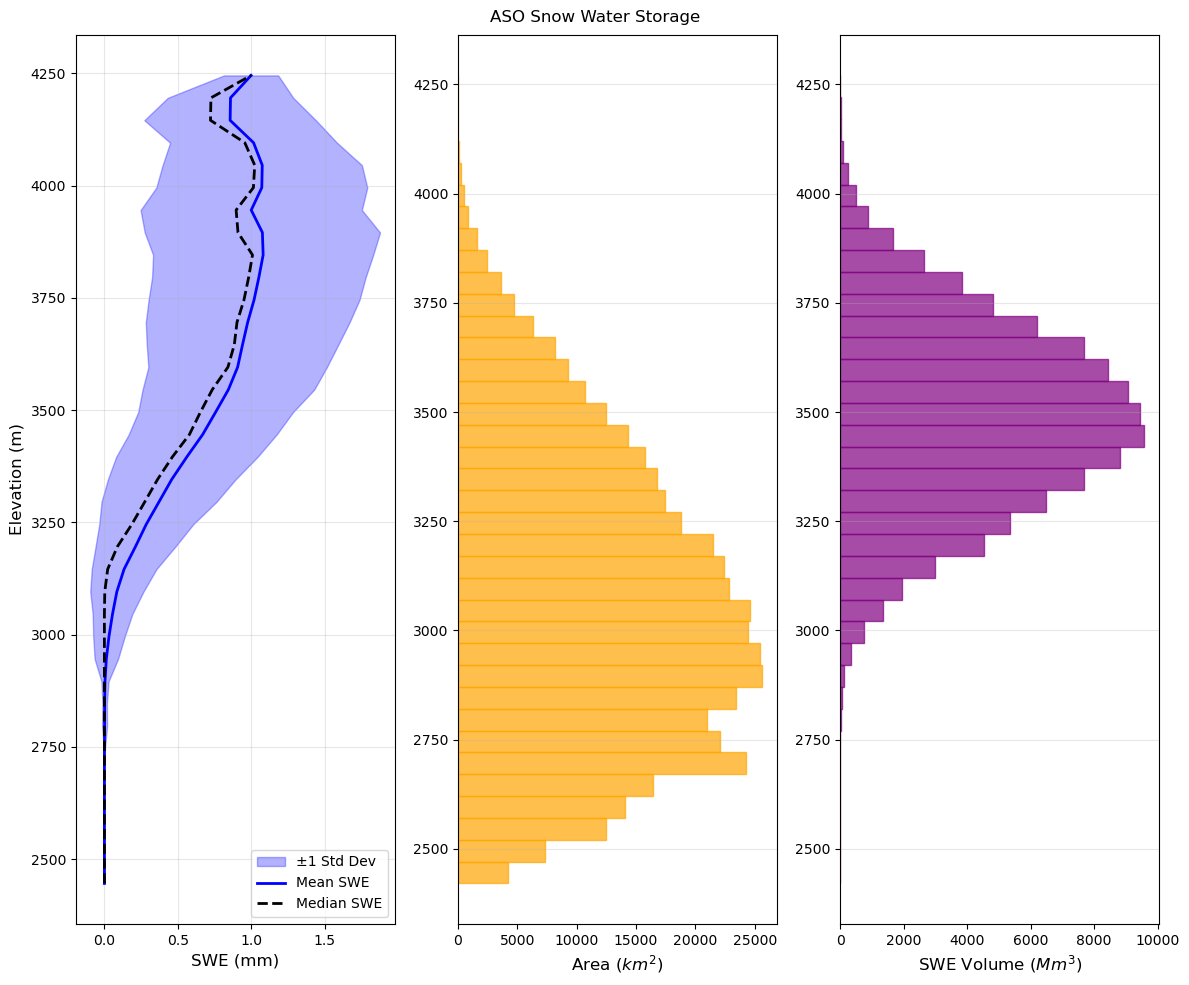

In [3]:
swe_vs_elevation(elev_fname, jun_2019, 50)